In [11]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import timedelta
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
from scipy.fft import fft, fftfreq

In [12]:
### ONLY RUN ONCE! ###
#download data from firebase
try:
    firebase_admin.delete_app(app)
except:
    print('making new app')
cred = credentials.Certificate("../../pc_basestation/fb_key.json")
app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

ref = db.reference('/egg_eye_1/fdata')
data = ref.get()

## Example Timeseries

The first data entry in the database is an anomaly generated by waving an object in front of the sensor. This is supposed to mimic eggs or debris passing the sensor in the tank. 

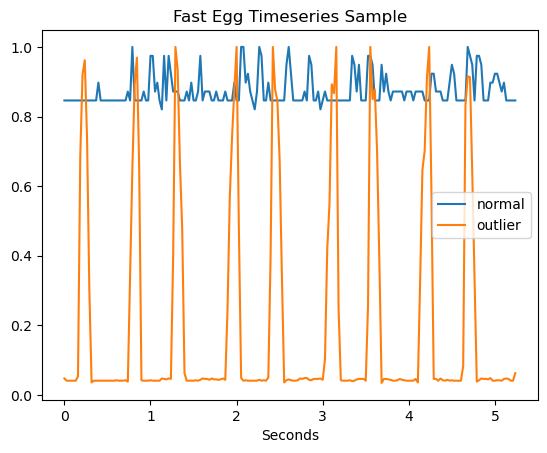

In [13]:
# sampling freq: 38 Hz
# total points per sample: 200
# start: 9:03
# anomalies ended: 9:05:10
x = np.arange(200)/38
y = np.array(data['20240227_09:05:25']['data']).astype('int')
y = y / y.max()
y1 = np.array(data['20240227_09:03:25']['data']).astype('int')
y1 = y1 / y1.max()

plt.figure()
plt.title("Fast Egg Timeseries Sample")
plt.xlabel("Seconds")
plt.plot(x,y)
plt.plot(x,y1)
plt.legend(['normal', 'outlier'])
plt.show()

## Preprocessing

The timeseries data is converted to the frequency domain using a fast fourier transform. This is the data that will be fed into the novelty detector. The first data entry 

20240227_09:03:25
20240227_09:05:10


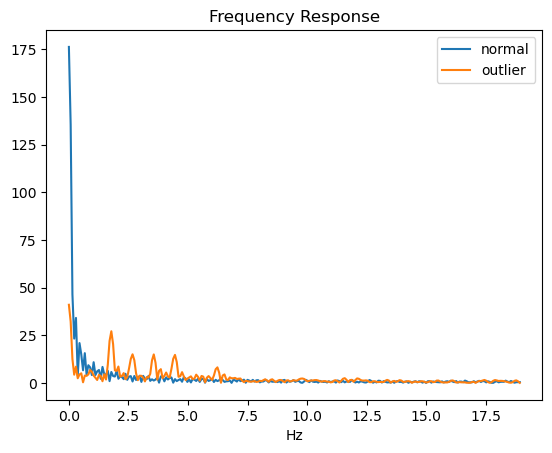

In [14]:
keys =  list(data.keys())

print(keys[760]) #first anomaly
print(keys[767]) #last anomaly (number 8)

#create an empty array
N = 512 # make a multiple of 2
fs = 38 # sampling frequency
X = np.zeros((len(keys[760:]), N//2))

#generate ffts for each entry
for i, k in enumerate(keys[760:]):
    x = np.array(data[k]['data']).astype('int')
    x = x / x.max() # normalize the data
    x_fft = fft(x, N)
    X[i] = np.abs(x_fft[:N//2])

X_train = X[10:, :]
X_test = X[:10, :]

#generate the range of frequencies corresponding with the ffts
freq_range = fftfreq(N, 1 / fs)[:N//2]

plt.figure()
plt.title("Frequency Response")
plt.xlabel("Hz")
plt.plot(freq_range, X_train[0])
plt.plot(freq_range, X_test[0])
plt.legend(['normal', 'outlier'])
plt.show()

## Novelty Detector

The following code uses the [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) to determine whether a data point is an outlier. There are several different algorithms that can serve as novelty/outlier detectors: https://scikit-learn.org/stable/modules/outlier_detection.html

The Local Outlier Factor outputs a binary classification for outlier/inlier:
- **1 : inlier**
- **-1 : outlier**

In `X_test` the first 8 samples should be considered outliers while the remaining 2 samples are inliers. The following algorithm correctly predicts all of the test samples.

In [15]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
lof.fit(X_train)
result = lof.predict(X_test)
print("prediction: ", result)

prediction:  [-1 -1 -1 -1 -1 -1 -1 -1  1  1]


## Website Visualizations

There are multiple graphs we could try displaying to convey the status of the tanks.

### Latest Timeseries

Just show the raw data and maybe the user can infer a pattern?

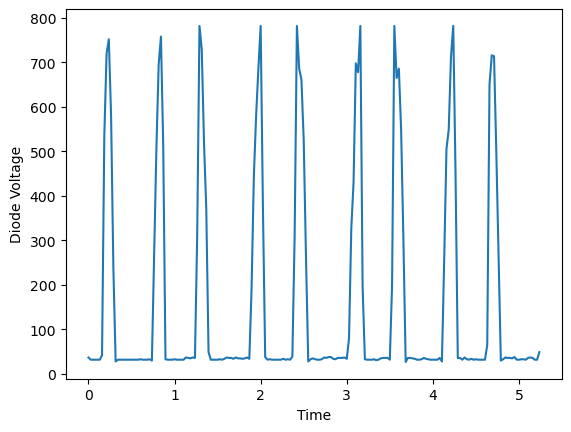

In [16]:
x_outlier = np.array(data[keys[760]]['data']).astype('int')
time = np.arange(200)/38

plt.figure()
plt.plot(time, x_outlier)
plt.xlabel("Time")
plt.ylabel("Diode Voltage")
plt.show()

### Frequency Data Vs. Avg. Frequency Data

User can determine whether new peaks or shifting peak frequencies correspond to an event in the tank. The DC value (Hz = 0) is removed because it overwhelms the graph.

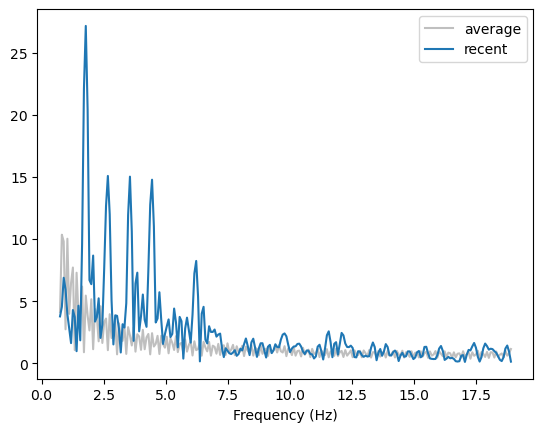

In [20]:
start = 10
plt.figure()
plt.plot(freq_range[start:], X_train.mean(axis=0)[start:], color='grey', alpha=0.5)
plt.plot(freq_range[start:], X_test[0][start:])
plt.xlabel("Frequency (Hz)")
plt.legend(['average', 'recent'])
plt.show()

### Anomaly Over Time

Plot the prediction from the anomaly detector over time. The presence of fish eggs should leave the output at a steady `anomaly` state. This graph would be useful to determine when an anomaly was triggered.

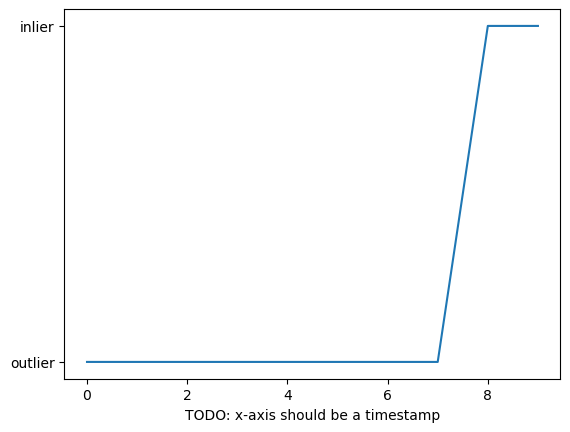

In [28]:
result_text = ['outlier' if i == -1 else 'inlier' for i in result]
plt.figure()
plt.plot(result_text)
plt.xlabel("TODO: x-axis should be a timestamp")
plt.show()